# Imports

In [ ]:
!pip install transformers
!pip install sentence_transformers
!pip install datasets
!pip install sentencepiece
!pip install scikit-learn-extra
!pip install wikipedia
!pip install eli5
!pip install lime


In [ ]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [ ]:
import math
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import argparse
from __future__ import print_function
from collections import Counter
import string
import re
import argparse
import json
import os
import random
import shutil
import wikipedia
import time
import torch.nn.parallel
import torch.backends.cudnn as cudnn
from tqdm import tqdm
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
from PIL import Image
import torch.utils.data as data
from torchvision.datasets.utils import download_url, check_integrity
import sys
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.gaussian_process.kernels import RBF
import torch
from sklearn.metrics.pairwise import rbf_kernel

from scipy.stats import multivariate_normal
import  scipy.stats as st
from matplotlib import cm
import torch.optim as optim
from __future__ import print_function
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, AdamW, AutoModel
import nltk
from torch.utils.data import DataLoader
import pickle
import spacy
from gensim import corpora, models, similarities
import gensim
from spacy.lang.en import English
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.cluster import KMeans
import pickle
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
import matplotlib
from sklearn.metrics.pairwise import rbf_kernel
import copy
import eli5
from eli5.lime import TextExplainer
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')

cuda:0
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# HotpotQA


In [ ]:
DISTRACTORS_PARS_LEN = 0

In [ ]:
from datasets import load_dataset

dataset = load_dataset("hotpot_qa", 'distractor')
train_dataset = dataset['train']
validation_dataset = dataset['validation']

Reusing dataset hotpot_qa (/root/.cache/huggingface/datasets/hotpot_qa/distractor/1.0.0/133b9501f892e5193babbad937bee3b4899deb4691ef4d791e6ac0111c875bb5)


In [ ]:
def get_token_lenght(context, question):
    inputs = tokenizer.encode_plus(question, context, add_special_tokens=True, return_tensors="pt")
    return len(inputs['input_ids'][0])

def remove_distractors(example, n_distractors = 0):
    all_pars = example['context']['title']
    gold_pars = list(set(example['supporting_facts']['title']))
    distractor_pars = list(set(all_pars) - set(gold_pars))
    # get indices to keep from disractors
    if len(distractor_pars) == 0 or n_distractors == 0:
        distract_indices = []
    else:
        distract_indices = random.sample(range(len(distractor_pars)), n_distractors)
    distractor_pars = [distractor_pars[idx] for idx in distract_indices]
    keep_pars = gold_pars + distractor_pars
    keep_pars_indices = [all_pars.index(keep_par) for keep_par in keep_pars]
    example['context']['title'] = [example['context']['title'][idx] for idx in keep_pars_indices]
    example['context']['sentences'] = [example['context']['sentences'][idx] for idx in keep_pars_indices]
    
    sentences_par = ["".join(example['context']['sentences'][idx]) for idx in range(len(example['context']['sentences']))]
    example['intros'] = " ".join([example['context']['sentences'][idx][0] for idx in range(len(example['context']['sentences']))])
    example['passage'] = " #$ ".join(sentences_par)
    return example

def remove_distractors_remove_key_sent(example, n_distractors = 0):
    all_pars = example['context']['title']
    gold_pars = list(set(example['supporting_facts']['title']))
    distractor_pars = list(set(all_pars) - set(gold_pars))
    # get indices to keep from disractors
    if len(distractor_pars) == 0 or n_distractors == 0:
        distract_indices = []
    else:
        distract_indices = random.sample(range(len(distractor_pars)), n_distractors)
    distractor_pars = [distractor_pars[idx] for idx in distract_indices]
    keep_pars = gold_pars + distractor_pars
    keep_pars_indices = [all_pars.index(keep_par) for keep_par in keep_pars]
    example['context']['title'] = [example['context']['title'][idx] for idx in keep_pars_indices]
    example['context']['sentences'] = [example['context']['sentences'][idx] for idx in keep_pars_indices]

    # removed all distractors, now we remove a key sentence
    rand_sup_idx =random.sample(list(range(len(example['supporting_facts']['sent_id']))), 1)[0] 
    title_to_index = {}
    for i in range(len(example['context']['title'])):
        title_to_index[example['context']['title'][i]] = i
    par_to_remove = title_to_index[example['supporting_facts']['title'][rand_sup_idx]]
    sent_to_remove = example['supporting_facts']['sent_id'][rand_sup_idx]
    sentencess = copy.deepcopy(example['context']['sentences'])
    able_to_remove = False
    times_tried = 0
    while not able_to_remove:
        if times_tried >4:
            print("giving up")
            break
        try:
            sent = sentencess[par_to_remove][sent_to_remove]
            if example['answer'] in sent:
                raise Exception('error')
            #sentencess[par_to_remove].pop(sent_to_remove)
            sentencess[par_to_remove][sent_to_remove] = " [...] . "
            able_to_remove = True
        except:
            times_tried += 1
            print("failed trying again")
            rand_sup_idx =random.sample(list(range(len(example['supporting_facts']['sent_id']))), 1)[0] 
            title_to_index = {}
            for i in range(len(example['context']['title'])):
                title_to_index[example['context']['title'][i]] = i
            par_to_remove = title_to_index[example['supporting_facts']['title'][rand_sup_idx]]
            sent_to_remove = example['supporting_facts']['sent_id'][rand_sup_idx]
            sentencess = copy.deepcopy(example['context']['sentences'])

    example['intros'] = " ".join([sentencess[idx][0] for idx in range(len(sentencess)) if len(sentencess[idx])>0])

    sentences_par = ["".join(sentencess[idx]) for idx in range(len(sentencess))]

    example['passage'] = " #$ ".join(sentences_par)
    return example




In [ ]:
train_dataset_hum = train_dataset.map(remove_distractors_remove_key_sent)
validation_dataset_hum = validation_dataset.map(remove_distractors_remove_key_sent)
train_dataset = train_dataset_hum#train_dataset.map(remove_distractors_remove_key_sent)
validation_dataset = validation_dataset_hum#validation_dataset.map(remove_distractors_remove_key_sent)

Streaming output truncated to the last 5000 lines.
failed trying again
failed trying again
giving up
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
giving up
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
giving up
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
giving up
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
giving up
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
giving up
failed trying again
failed trying again
failed tr

Streaming output truncated to the last 5000 lines.
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
giving up
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
giving up
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
giving up
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
giving up
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed trying again
failed tr

In [ ]:
# Free form vs yes/no
all_indices = set(list(range(len(validation_dataset))))
yes_no_indices = set([i  for i in range(len(validation_dataset)) if validation_dataset[i]['answer'] in ["yes","no"] ])
free_indices_val = all_indices - yes_no_indices
all_indices = set(list(range(len(train_dataset))))
yes_no_indices_train = set([i  for i in range(len(train_dataset)) if (train_dataset[i]['answer'] in ["yes","no"]) or (train_dataset[i]['level'] in ['easy','medium']) ])
free_indices_train = all_indices - yes_no_indices_train
print(len(free_indices_val))
print(len(free_indices_train))


6947
14631


In [ ]:
hard_dataset = [train_dataset[i] for i in free_indices_train ]
hard_dataset += [validation_dataset[i] for i in free_indices_val]
dataset_indices =  set(list(range(len(hard_dataset))))
VAL_START = len([train_dataset[i] for i in free_indices_train ])
len(hard_dataset)

21578

In [ ]:
VAL_START

14631

In [ ]:
hard_dataset[0]['passage']

'Allison Beth "Allie" Goertz (born March 2, 1991) is an American musician. Goertz is known for her satirical songs based on various pop culture topics. [...] .  Subjects of her songs have included the film "The Room", the character Milhouse from the television show "The Simpsons", and the game Dungeons & Dragons. Her style has been compared to that of Bo Burnham. In December 2015, Goertz released a concept album based on the Adult Swim series "Rick and Morty", "Sad Dance Songs", with the album\'s cover emulating the animation and logo of the series. The album was made possible through Kickstarter. She is co-host of Everything\'s Coming Up Podcast, a Simpsons-focused podcast along with Julia Prescott. #$ Milhouse Mussolini van Houten is a fictional character featured in the animated television series "The Simpsons", voiced by Pamela Hayden, and created by Matt Groening who named the character after President Richard Nixon\'s middle name. Later in the series, it is revealed that Milhouse

## Utils

In [ ]:

def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)

    def lower(text):
        return text.lower()

    return white_space_fix(remove_articles(remove_punc(lower(s))))


def f1_score(prediction, ground_truth):
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def exact_match_score(prediction, ground_truth):
    return (normalize_answer(prediction) == normalize_answer(ground_truth))


def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)
    return max(scores_for_ground_truths)



def evaluate_truth_pred(truths, preds):
    '''
    truths, preds: matched arrays of ground truth answers and predictions
    '''
    f1 = exact_match = total = 0
    for i in range(len(truths)):
        total += 1
        if truths[i] in ['yes', "no"]:
            continue
        ground_truths = [truths[i]]
        prediction = preds[i]
        exact_match += metric_max_over_ground_truths(
            exact_match_score, prediction, ground_truths)
        f1 += metric_max_over_ground_truths(
            f1_score, prediction, ground_truths)

    exact_match = 100.0 * exact_match / (total+ 0.00000000001)
    f1 = 100.0 * f1 / (total+ 0.00000000001)

    return {'exact_match': exact_match, 'f1': f1}


def get_answer( model, tokenizer, context, question):
    # 1. TOKENIZE THE INPUT
    # note: if you don't include return_tensors='pt' you'll get a list of lists which is easier for
    # exploration but you cannot feed that into a model.
    inputs = tokenizer.encode_plus(question, context, return_tensors="pt")
    inputs = inputs.to(device)
    # 2. OBTAIN MODEL SCORES
    # the AutoModelForQuestionAnswering class includes a span predictor on top of the model.
    # the model returns answer start and end scores for each word in the text
    answer_start_scores, answer_end_scores = model(**inputs, return_dict=False)
    answer_start = torch.argmax(answer_start_scores)  # get the most likely beginning of answer with the argmax of the score
    answer_end = torch.argmax(answer_end_scores) + 1  # get the most likely end of answer with the argmax of the score
    # 3. GET THE ANSWER SPAN
    # once we have the most likely start and end tokens, we grab all the tokens between them
    # and convert tokens back to words!
    answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][answer_start:answer_end]))
    return answer
# https://huggingface.co/transformers/migration.html
def model_evaluation(model, tokenizer, questions, contexts, answers, to_print = False):
    preds = []
    my_list = list(range(len(questions)))
    with tqdm(total=len(my_list)) as pbar:
        for ex in range(len(questions)):
            answer = get_answer(model, tokenizer, contexts[ex],questions[ex])
            preds.append(answer)
            if ex % 100 == 0 and to_print:
                print("context " +contexts[ex] )
                print("quest " +questions[ex] )
                print("truth " +answers[ex]['text'] )
                print("pred " + answer)
            pbar.update(1)
    truths = [answers[i]['text'] for i in range(len(answers))]
    scores = evaluate_truth_pred(truths, preds)
    print(scores)
    return scores




# FakeAI model

In [ ]:
class FakeAI:
    r"""
    FakeAI that is incorrect in random clusters in the input space
    
    Args:
        train_passages: list of embedded passages
        train_questions: list of embedded questions
        n_clus_p: number of centroids in kmeans for passages
        n_clus_q: number of centroids in kmeans for questions
        clust_err_p: clusters where AI makes error on passages
        clust_err_q: clusters where AI makes error on questions
    """
    def __init__(self, train_passages, train_questions, n_clus_p, n_clus_q, n_clust_err_p, n_clust_err_q):
 
        self.train_passages = train_passages
        self.train_questions = train_questions
        self.n_clus_p = n_clus_p
        self.n_clus_q = n_clus_q
        self.n_clust_err_p = n_clust_err_p
        self.n_clust_err_q = n_clust_err_q
        self.build_kmeans()
        self.clust_err_p = random.sample(list(range(self.n_clus_p)), self.n_clust_err_p)
        self.clust_err_q = random.sample(list(range(self.n_clus_q)), self.n_clust_err_q)
        
        
    def build_kmeans(self):
        # Builds kmeans for passages and questions
        self.kmeans_quest = KMeans(n_clusters=self.n_clus_q, max_iter = 10000, random_state = 66).fit(self.train_questions)
        self.kmeans_pass = KMeans(n_clusters=self.n_clus_p, max_iter = 100000, random_state = 66).fit(self.train_passages)

    def predict_right_wrong(self, passages, questions):
        '''
        Args:
            passages: list of embedded passages
            questions: list of embedded questions (same size as passages)
        Returns:
            preds: binary array indicating if AI is right (1) or wrong (0)
        '''
        clusts_p = self.kmeans_pass.predict(passages)
        clusts_q = self.kmeans_quest.predict(questions)
        preds = []
        for i in range(len(clusts_p)):
            if (clusts_p[i] in self.clust_err_p) or (clusts_q[i] in self.clust_err_q):
                preds.append(0)
            else:
                preds.append(1)
        return preds

    def predict_proba(self, raw_passages):
        embed_ps = model.encode(raw_passages)
        embed_ps = [embed_ps[i] for i in range(len(embed_ps))]
        clusts_p = self.kmeans_pass.predict(embed_ps)
        preds = []
        for i in range(len(clusts_p)):
            if (clusts_p[i] in self.clust_err_p):
                preds.append([0.0,1.0])
            else:
                preds.append([1.0,0.0])
        return np.asarray(preds)


def is_a_stopword(feature, weight):
    split_words = feature.split(' ')
    for word in split_words:
        if word in stopwords:
            return False
    return True

def get_highlighted_p(ai_model, paragraph):
    '''
    from https://eli5.readthedocs.io/en/latest/tutorials/black-box-text-classifiers.html#lime-tutorial
    '''
    
    te = TextExplainer(random_state=42)
    te.fit(paragraph, ai_model.predict_proba)
    show_pred = te.show_prediction(target_names=['correct','false'], top=(8,0), feature_filter = is_a_stopword)
    correct = False
    if show_pred.data.find("y=correct") != -1:
        correct = True
    b = show_pred.data.split('<p style="margin-bottom: 2.5em; margin-top:-0.5em;">')
    to_show = '<p style="margin-bottom: 2.5em; margin-top:-0.5em;">' +b[-1]
    if not correct:
        to_show = to_show.replace("hsl(120,","hsl(0,")
    return to_show

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-distilroberta-base-v1') #distilbert-base-nli-stsb-mean-tokens
# https://www.sbert.net/docs/pretrained_models.html

# Check clusters 

In [ ]:
all_passages = [hard_dataset[i]['passage'] for i in range(VAL_START,len(dataset_indices))]
embeddings_passage = model.encode(all_passages)


In [ ]:
N_CLUSTERS = 20
for k in range(5,30):
    kmeans_pass = KMeans(n_clusters=k,max_iter = 10000, random_state = 66).fit(embeddings_passage)
    print(f'For k {k} inertia is {kmeans_pass.inertia_:.3f}')    

In [ ]:
N_CLUSTERS = 25
kmeans_pass = KMeans(n_clusters=25, max_iter = 100000, n_init = 200).fit(embeddings_passage)
print(f'For k {N_CLUSTERS} inertia is {kmeans_pass.inertia_:.3f}')    

For k 25 inertia is 220485.172


In [ ]:
220397.344

In [ ]:
all_categories = []
def is_valid(title):
    not_allowed = ["Wikipedia","Wikidata", "articles","Articles","Year of birth","Living people"]
    for term in not_allowed:
        if term in title:
            return False
    return True

for i in range(0, len(all_passages)):
    if i % 50 == 0:
        print(i)
    #result_search = search(all_passages[i][0:100], tld='com', lang='en', num=2, start=0, stop=1, pause=1.0)
    #search_result = next(result_search)
    #if "wiki" not in search_result:
    article_passage = wikipedia.search(all_passages[i][0:30])
    if len(article_passage) == 0:
        article_passage = wikipedia.search(all_passages[i][0:20])
        if len(article_passage) == 0:
            article_passage = wikipedia.search(all_passages[i][0:10])
            if len(article_passage) == 0:
                article_passage = wikipedia.search(all_passages[i][0:5])
                if len(article_passage) == 0:
                    print("couldnt find anything, stopped trying")
                    all_categories.append([])
                    continue
                else:
                    article_passage = article_passage[0]
            else:
                article_passage = article_passage[0]
        else:
            article_passage = article_passage[0]

    else:
        article_passage = article_passage[0]
    '''
    else:
       article_passage = wikipedia.search(search_result.split('/wiki/')[1])
        if len(article_passage) == 0:
            all_categories.append([])
            continue
        else:
            article_passage = article_passage[0]
    '''
    try:
        wiki_page = wikipedia.WikipediaPage(article_passage)
        categs = wiki_page.categories
        categs = [categs[i] for i in range(len(categs)) if is_valid(categs[i])]
        all_categories.append(categs)
    except:
        print("something bad happened")
        all_categories.append([])        
        
        

In [ ]:
from sklearn_extra.cluster import KMedoids

passages = [[] for _ in range(N_CLUSTERS)]
embeddings = [[] for _ in range(N_CLUSTERS)]
categories = [[] for _ in range(N_CLUSTERS)]
for i in range(len(all_categories)):
    cluster_index = kmeans_pass.labels_[i]
    passages[cluster_index].append(all_passages[i])
    embeddings[cluster_index].append(embeddings_passage[i])
    for categ in all_categories[i]:
        categories[cluster_index].append(categ)
    #hard_dataset
    #if (cluster_index == 0): #and (i%2 == 0):
        #print("###############")
        #print(validation_dataset[i]['answer'])
        #print(hard_dataset[i]['passage'])
        #print(validation_dataset[i]['question'])

              #      print(validation_dataset[i]['answer'])
from collections import Counter


for i in range(N_CLUSTERS):
    print("########################################")
    print("############## CLUSTER "+str(i)+"##############")
    print("########################################")
    #if i not in [5]:
    #    continue
    
    c = Counter(categories[i])
    mc = c.most_common(30)
    for tt in mc:
        if "CS1" not in tt[0] and "Pages" not in tt[0] and "Webarchive" not in tt[0] :
            print(tt[0])
    #print(c.most_common(20))

    print("\n")

(array([258., 424., 119., 298., 532., 287., 443., 289., 315., 360., 288.,
        177., 137., 140., 180., 256., 343., 230., 352., 284., 230., 238.,
        308., 220., 239.]),
 array([ 0.  ,  0.96,  1.92,  2.88,  3.84,  4.8 ,  5.76,  6.72,  7.68,
         8.64,  9.6 , 10.56, 11.52, 12.48, 13.44, 14.4 , 15.36, 16.32,
        17.28, 18.24, 19.2 , 20.16, 21.12, 22.08, 23.04, 24.  ]),
 <a list of 25 Patch objects>)

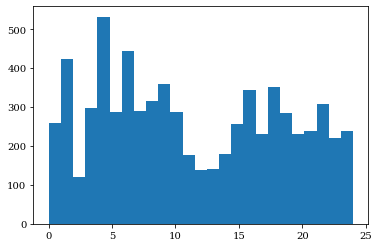

In [ ]:
plt.hist(kmeans_pass.labels_, bins=N_CLUSTERS)

In [ ]:
pickle.dump(kmeans_pass,open("25_kmeans.p","wb"))

Understand the topic of clusters from wikipedia categories of articles

In [ ]:
from sklearn_extra.cluster import KMedoids

passages = [[] for _ in range(N_CLUSTERS)]
embeddings = [[] for _ in range(N_CLUSTERS)]
categories = [[] for _ in range(N_CLUSTERS)]
for i in range(len(all_passages)):
    cluster_index = kmeans_pass.labels_[i]
    passages[cluster_index].append(all_passages[i])
    embeddings[cluster_index].append(embeddings_passage[i])

for i in range(N_CLUSTERS):
    print("########################################")
    print("############## CLUSTER "+str(i)+"##############")
    print("########################################")
    #if i not in [5]:
    #    continue
    
    passage_sub = random.sample(list(range(len(passages[i]))),5)
    for j in passage_sub:
        print("%%%%%%%%%%%%%%%")
        print(passages[i][j])    
    



# Teaching User Interface



## Human classes and utilities

In [ ]:
class HumanPredictor_simple:
    def __init__(self, accuracy, reject_percent):
        '''
        accuracy and reject_percent: floats in [0,1]
        '''
        self.accuracy = accuracy
        self.reject_percent = reject_percent

    def predict(self, contexts, questions, answers):
        '''
        expects array of strings for inputs
        returns list of string answer
        '''
        preds = []
        for i in range(len(answers)):
            coin = random.random() # random number between [0,1]
            if coin <= self.accuracy:
                preds.append(answers[i])
            else:
                # generate random answer
                sents = nltk.sent_tokenize(contexts[i])
                rand_sent = random.randint(0,len(sents)-1)
                preds.append(sents[rand_sent])
        return preds
    def prior_rejector(self, contexts, questions, answers):
        '''
        this rejector is agnostic to input, random deferall 1-self.accuracy times
        '''
        preds = []
        for i in range(len(answers)):
            coin = random.random() # random number between [0,1]
            if coin <= self.reject_percent:
                preds.append(1)
            else:
                preds.append(0)
        return preds

In [ ]:
class HumanLearner:
    def __init__(self, kernel):
        '''
        kernel: function that takes two inputs and returns a similarity
        prior rejector: returns rejector
        '''
        self.teaching_set = []
        self.kernel = kernel
    def predict(self, xs, prior_rejector_preds, to_print = False):
        '''
        xs: expected array of inputs
        '''
        preds = []
        idx = 0
        used_posterior = 0 
        if to_print:
            print("-- Human making reject predictions --")
            with tqdm(total=len(xs)) as pbar:
                for x in xs:
                    ball_at_x = []
                    similarities = rbf_kernel(x.reshape(1,-1), np.asarray([self.teaching_set[kk][0] for kk in range(len(self.teaching_set))]))[0]
                    for i in range(len(self.teaching_set)):
                        similarity = similarities[i]
                        if similarity >=  self.teaching_set[i][2]:
                            ball_at_x.append(self.teaching_set[i])
                    if len(ball_at_x) == 0: 
                        # use prior rejector
                        preds.append(prior_rejector_preds[idx])
                    else:
                        used_posterior += 1
                        ball_similarities = rbf_kernel(x.reshape(1,-1), np.asarray([ball_at_x[kk][0] for kk in range(len(ball_at_x))]))[0]
                        normalization = np.sum([ball_similarities[i] for i in range(len(ball_at_x))])
                        score_one = np.sum([ball_similarities[i]*ball_at_x[i][1] for i in range(len(ball_at_x))])
                        pred = score_one / normalization
                        if pred >= 0.5:
                            preds.append(1)
                        else:
                            preds.append(0)
                    idx += 1
                    pbar.update(1)
        else:
            for x in xs:
                ball_at_x = []
                similarities = rbf_kernel(x.reshape(1,-1), np.asarray([self.teaching_set[kk][0] for kk in range(len(self.teaching_set))]))[0]
                for i in range(len(self.teaching_set)):
                    similarity = similarities[i]
                    if similarity >=  self.teaching_set[i][2]:
                        ball_at_x.append(self.teaching_set[i])
                if len(ball_at_x) == 0: 
                    # use prior rejector
                    preds.append(prior_rejector_preds[idx])
                else:
                    used_posterior += 1
                    ball_similarities = rbf_kernel(x.reshape(1,-1), np.asarray([ball_at_x[kk][0] for kk in range(len(ball_at_x))]))[0]
                    normalization = np.sum([ball_similarities[i] for i in range(len(ball_at_x))])
                    score_one = np.sum([ball_similarities[i]*ball_at_x[i][1] for i in range(len(ball_at_x))])
                    pred = score_one / normalization
                    if pred >= 0.5:
                        preds.append(1)
                    else:
                        preds.append(0)
                idx += 1
        if to_print:
            print(f'Used posterior {used_posterior/len(xs)*100:.2f}')
        return preds

    def add_to_teaching(self, teaching_example):
        '''
        teaching_example: (x, label, gamma)
        '''
        self.teaching_set.append(teaching_example)

    def remove_last_teaching_item(self):
        self.teaching_set = self.teaching_set[:-1]

In [ ]:
def compute_predictions_humanai(hum_preds, hum_rejector, ai_preds, data_x):
    '''
    hum_preds: array of human predictions
    ai_preds: array of AI predictions
    hum_rejector: HumanLearner
    data_x: array of inputs

    Returns array of final predictions and deferalls
    '''
    predictions = []
    with torch.no_grad():
        reject_decisions = hum_rejector(data_x)
        for i in range(len(data_x)):
            if reject_decisions[i] == 1:
                # defer
                predictions.append(ai_preds[i])
            else:
                predictions.append(hum_preds[i])
    return predictions, reject_decisions

def get_metrics(preds, truths):
    # custom for each use case
    return evaluate_truth_pred(truths, preds)

def compute_metrics(human_preds, ai_preds, reject_decisions, truths, to_print = False):
    coverage = 1 - np.sum(reject_decisions)/len(reject_decisions)
    humanai_preds = []
    human_preds_sys = []
    truths_human = []
    ai_preds_sys = []
    truths_ai = []
    for i in range(len(reject_decisions)):
        if reject_decisions[i] == 1:
            humanai_preds.append(ai_preds[i])
            ai_preds_sys.append(ai_preds[i])
            truths_ai.append(truths[i])
        else:
            humanai_preds.append(human_preds[i])
            human_preds_sys.append(human_preds[i])
            truths_human.append(truths[i])
    humanai_metrics = get_metrics(humanai_preds, truths)
    human_metrics = get_metrics(human_preds_sys, truths_human)
    ai_metrics = get_metrics(ai_preds_sys, truths_ai)
    if to_print:
        print(f'Coverage is {coverage*100:.2f}')
        print(f' metrics of system are: {humanai_metrics}')
        print(f' metrics of human are: {human_metrics}')
        print(f' metrics of AI are: {ai_metrics}')
    return coverage, humanai_metrics, human_metrics, ai_metrics

## Get predictions

In [ ]:
# Preliminary steps:
# Step 1.1: get predictions of human and predictions of AI on teaching set
# Step 1.2: get prior rejector decisions of Human on teaching set
# Step 2: Compute optimal deferal decision for each point in teaching set  
# Step 3: Compute optimal gamma for each point, can start with a constant guess

# Algorithms:
# Initialize HumanLearner
# Baseline 1:
# step 1: get k-mediods points
# step 2: add to HumanLearner
# step 3: evaluate on validation set

In [ ]:
# Define teaching and validation
random.seed(66)
all_passages = [validation_dataset[i]['passage'] for i in free_indices_val]
embeddings_passage = model.encode(all_passages)
embeddings_passage = [embeddings_passage[i] for i in range(len(embeddings_passage))]

all_questions = [validation_dataset[i]['question'] for i in free_indices_val]
embeddings_question = model.encode(all_questions)
all_answers = [validation_dataset[i]['answer'] for i in free_indices_val]
embeddings_ans= model.encode(all_answers)
all_sentences =  [validation_dataset[i]['context']['sentences'] for i in free_indices_val]
train_size = math.floor(0.8 * len(free_indices_val))
train_indices = random.sample(list(range(len(free_indices_val))), train_size)
dataset_indices =  set(list(range(len(all_answers))))
test_indices = list(dataset_indices - set(train_indices))

train_passages = [embeddings_passage[i] for i in train_indices]
train_questions = [embeddings_question[i] for i in train_indices]
test_passages = [embeddings_passage[i] for i in test_indices]
test_questions = [embeddings_question[i] for i in test_indices]
train_sentences = [all_sentences[i] for i in train_indices]
test_sentences = [all_sentences[i] for i in test_indices]

train_answers = [all_answers[i] for i in train_indices]
test_answers = [all_answers[i] for i in test_indices]
train_raw_passages = [all_passages[i] for i in train_indices]
test_raw_passages = [all_passages[i] for i in test_indices]
train_raw_questions= [all_questions[i] for i in train_indices]
test_raw_questions = [all_questions[i] for i in test_indices]


In [ ]:
all_passages = [validation_dataset_hum[i]['passage'] for i in free_indices_val]
train_raw_passages_hum = [all_passages[i] for i in train_indices]
test_raw_passages_hum = [all_passages[i] for i in test_indices]


In [ ]:
# Get Human Predictions
HUMAN_ACCURACY = 0.8
REJECT_PERCENT = 0.5
hum_teaching_preds = []
hum_validation_preds = []
priorhum_teaching_preds = []
priorhum_validation_preds = []

human_predictor = HumanPredictor_simple(HUMAN_ACCURACY, REJECT_PERCENT)
hum_teaching_preds = []
hum_validation_preds = []
priorhum_teaching_preds = []
priorhum_validation_preds = []
print("--Getting Human predictions on teach and validation sets --\n")
hum_teaching_preds = human_predictor.predict(train_raw_passages, train_answers, train_answers)
hum_validation_preds = human_predictor.predict(test_raw_passages, test_answers, test_answers)
print("--Getting prior rejector predictions on teach and validation sets") 
priorhum_teaching_preds = human_predictor.prior_rejector(train_raw_passages, train_answers, train_answers)
priorhum_validation_preds = human_predictor.prior_rejector(test_raw_passages, test_answers, test_answers)

'''
ai_val_preds = []
with open('C:/Users/Hussein/Documents/Research/Human learn to defer/hotpotqa/outputs_val_1dis/predictions_ans.json', 'r') as handle:
    preds_val = json.load(handle)
    
for key, value in preds_val.items():
    ai_val_preds.append(value)

ai_val_preds = [ai_val_preds[i] for i in free_indices_val]
hum_teaching_preds =  [ai_val_preds[i] for i in train_indices]
hum_validation_preds =  [ai_val_preds[i] for i in test_indices]

log_odds_ai = []
with open('C:/Users/Hussein/Documents/Research/Human learn to defer/hotpotqa/outputs_val_1dis/null_odds_ans.json', 'r') as handle:
    preds_val = json.load(handle)
    
for key, value in preds_val.items():
    log_odds_ai.append(value)
log_odds_ai = [log_odds_ai[i] for i in free_indices_val]
log_odds_ai_train =  [log_odds_ai[i] for i in train_indices]
log_odds_ai_test =  [log_odds_ai[i] for i in test_indices]
epsilon = 0.2
threshold_odds = np.quantile(log_odds_ai_train, epsilon)
for i in range(len(log_odds_ai_train)):
    if log_odds_ai_train[i]>= threshold_odds:
        priorhum_teaching_preds.append(0)
    else:
        priorhum_teaching_preds.append(1)
        
for i in range(len(log_odds_ai_test)):
    if log_odds_ai_test[i]>= threshold_odds:
        priorhum_validation_preds.append(0)
    else:
        priorhum_validation_preds.append(1)
'''

--Getting Human predictions on teach and validation sets --

--Getting prior rejector predictions on teach and validation sets


"\nai_val_preds = []\nwith open('C:/Users/Hussein/Documents/Research/Human learn to defer/hotpotqa/outputs_val_1dis/predictions_ans.json', 'r') as handle:\n    preds_val = json.load(handle)\n    \nfor key, value in preds_val.items():\n    ai_val_preds.append(value)\n\nai_val_preds = [ai_val_preds[i] for i in free_indices_val]\nhum_teaching_preds =  [ai_val_preds[i] for i in train_indices]\nhum_validation_preds =  [ai_val_preds[i] for i in test_indices]\n\nlog_odds_ai = []\nwith open('C:/Users/Hussein/Documents/Research/Human learn to defer/hotpotqa/outputs_val_1dis/null_odds_ans.json', 'r') as handle:\n    preds_val = json.load(handle)\n    \nfor key, value in preds_val.items():\n    log_odds_ai.append(value)\nlog_odds_ai = [log_odds_ai[i] for i in free_indices_val]\nlog_odds_ai_train =  [log_odds_ai[i] for i in train_indices]\nlog_odds_ai_test =  [log_odds_ai[i] for i in test_indices]\nepsilon = 0.2\nthreshold_odds = np.quantile(log_odds_ai_train, epsilon)\nfor i in range(len(log_odds

In [ ]:
# Get AI predictions

ai_teaching_preds = []
ai_validation_preds = []
fakeai = FakeAI(embeddings_passage, embeddings_passage, 15, 15, 6, 1)
ai_teaching_preds_b = fakeai.predict_right_wrong(train_passages, train_questions)
ai_validation_preds_b = fakeai.predict_right_wrong(test_passages, test_questions)
print("percentage right test " + str(np.sum(ai_validation_preds_b)/len(test_indices)*100))
print("percentage right train " + str(np.sum(ai_teaching_preds_b)/len(train_indices)*100))
ai_teaching_preds = []
for i in range(len(ai_teaching_preds_b)):
    if ai_teaching_preds_b[i] == 1:
        ai_teaching_preds.append(train_answers[i])
    else:
        # generate random answer
        sents = nltk.sent_tokenize(train_raw_passages[i].replace("#$","</br> </br>"))
        rand_sent = random.randint(0,len(sents)-1)
        ai_teaching_preds.append(sents[rand_sent])

ai_validation_preds = []
for i in range(len(ai_validation_preds_b)):
    if ai_validation_preds_b[i] == 1:
        ai_validation_preds.append(test_answers[i])
    else:
        # generate random answer
        sents = nltk.sent_tokenize(test_raw_passages[i].replace("#$","</br> </br>"))
        rand_sent = random.randint(0,len(sents)-1)
        ai_validation_preds.append(sents[rand_sent])




percentage right test 63.812949640287776
percentage right train 63.28954471837322


In [ ]:
pickle.dump(fakeai, open("fakeai.p","wb"))


In [ ]:
# get embeddings for teaching set 
#teaching_embeddings = np.asarray([np.concatenate([train_passages[i],train_questions[i]]) for i in range(len(train_questions))])
teaching_embeddings = np.asarray([np.concatenate([train_passages[i]]) for i in range(len(train_questions))])

#validation_embeddings = np.asarray([np.concatenate([test_passages[i],test_questions[i]]) for i in range(len(test_passages))])
validation_embeddings = np.asarray([np.concatenate([test_passages[i]]) for i in range(len(test_passages))])


## Get gammas and optimal defer decisions

In [ ]:
# Optimal deferall decisions
opt_defer_teaching = []
opt_defer_validation = []
for ex in range(len(hum_teaching_preds)):
    f1_hum = metric_max_over_ground_truths(f1_score, train_answers[ex], [hum_teaching_preds[ex]])
    f1_ai = metric_max_over_ground_truths(f1_score, train_answers[ex], [ai_teaching_preds[ex]])

    if f1_ai >= f1_hum and f1_ai >= 0.9:
        opt_defer_teaching.append(1)
    else:
        opt_defer_teaching.append(0)

for ex in range(len(hum_validation_preds)):
    f1_hum = metric_max_over_ground_truths(f1_score, test_answers[ex], [hum_validation_preds[ex]])
    f1_ai = metric_max_over_ground_truths(f1_score, test_answers[ex], [ai_validation_preds[ex]])
    if f1_ai >= f1_hum and f1_ai >= 0.9:
        opt_defer_validation.append(1)
    else:
        opt_defer_validation.append(0)

In [ ]:
compute_metrics(hum_validation_preds, ai_validation_preds, priorhum_validation_preds, test_answers)

(0.4798561151079137,
 {'exact_match': 68.48920863309303, 'f1': 70.15067267753015},
 {'exact_match': 79.46026986506628, 'f1': 80.723454133884},
 {'exact_match': 58.36791147994387, 'f1': 60.396806520699286})

In [ ]:
compute_metrics(hum_validation_preds, ai_validation_preds, opt_defer_validation, test_answers)

(0.43453237410071943,
 {'exact_match': 91.79856115107847, 'f1': 92.36999509507586},
 {'exact_match': 81.1258278145682, 'f1': 82.44088275191312},
 {'exact_match': 99.99999999999872, 'f1': 99.99999999999872})

In [ ]:
compute_metrics(hum_teaching_preds, ai_teaching_preds, priorhum_teaching_preds, train_answers)

(0.49019254993701633,
 {'exact_match': 68.40021594385448, 'f1': 70.34521067293402},
 {'exact_match': 79.11160058737123, 'f1': 80.39077164171734},
 {'exact_match': 58.10095305330018, 'f1': 60.686153814845184})

In [ ]:
compute_metrics(hum_teaching_preds, ai_teaching_preds, opt_defer_teaching, train_answers)

(0.43152780277127945,
 {'exact_match': 91.07432067662391, 'f1': 91.604251704099},
 {'exact_match': 79.31609674728908, 'f1': 80.54413124256833},
 {'exact_match': 99.99999999999969, 'f1': 99.99999999999969})

In [ ]:
# get optimal gammas
optimal_gammas = []
with tqdm(total=len(teaching_embeddings)) as pbar:
    similarities_embeds_all = rbf_kernel( np.asarray(teaching_embeddings), np.asarray(teaching_embeddings))
    for i in range(len(teaching_embeddings)):
        # get all similarities
        similarities_embeds = similarities_embeds_all[i]
        opt_defer_ex = opt_defer_teaching[i]
        opt_gamma = 1
        sorted_sim = sorted([(similarities_embeds[k], opt_defer_teaching[k]) for k in range(len(teaching_embeddings))], key=lambda tup: tup[0])
        indicess = list(range(1, len(opt_defer_teaching)))
        indicess.reverse()
        for k in indicess:
            if sorted_sim[k][1] == opt_defer_ex and sorted_sim[k- 1][1] != opt_defer_ex:
                opt_gamma = sorted_sim[k][0]
                break
        threshold_gammas = [np.quantile(similarities_embeds, k) for k in [0.2,0.5,0.6,0.7,0.8,0.9,0.95]] + [opt_gamma]
        optimal_gammas.append(opt_gamma)
        pbar.update(1)

100%|█████████████████████████████████████████████████████████████████████████████| 5557/5557 [00:34<00:00, 161.41it/s]


In [ ]:
np.random.rand(20)

array([0.20602105, 0.97075412, 0.4588929 , 0.09656753, 0.36992404,
       0.60270206, 0.21685743, 0.50838705, 0.50990009, 0.39520443,
       0.33276755, 0.81067271, 0.17923192, 0.64719421, 0.26826368,
       0.97402615, 0.37220131, 0.94601184, 0.6232108 , 0.62706666])

In [ ]:
def get_improvement_defer(current_defer_preds, opt_defer_preds, gammas, xs):
    error_improvements = []
    similarities_embeds_all = rbf_kernel(np.asarray(xs), np.asarray(xs))
    error_at_i = 0
    for i in range(len(gammas)):
        error_at_i = 0
        similarities_embeds = similarities_embeds_all[i]
        for j in range(len(similarities_embeds)):
            if similarities_embeds[j] >= gammas[i]:
                f1_hum = metric_max_over_ground_truths(f1_score, train_answers[j], [hum_teaching_preds[j]]) # pass as param plz
                f1_ai = metric_max_over_ground_truths(f1_score, train_answers[j], [ai_teaching_preds[j]])# pass as param plz
                if opt_defer_preds[i] == 1:
                    if current_defer_preds[j] == 0:
                        error_at_i += f1_ai - f1_hum

                else:
                    if current_defer_preds[j] == 1:
                        error_at_i += f1_hum - f1_ai

        error_improvements.append(error_at_i)
        # get the ball for x
        # in this ball how many does the current defer not match the optimal
    return error_improvements

In [ ]:
b = get_improvement_defer(priorhum_teaching_preds, opt_defer_teaching, optimal_gammas, teaching_embeddings)
sorted(b, reverse = True)[:100]

## Selection Algorithm

In [ ]:
MAX_SIZE = 15
human_learner = HumanLearner(None)
errors = []
data_sizes  = []
indices_used = []
points_chosen = []
for itt in range(MAX_SIZE):
    print(f'New size {itt}')
    best_index = -1
    # predict with current human learner
    if itt == 0:
        preds_teach = priorhum_teaching_preds
    else:
        preds_teach = human_learner.predict(teaching_embeddings, priorhum_teaching_preds)
    error_improvements = get_improvement_defer(preds_teach, opt_defer_teaching, optimal_gammas, teaching_embeddings)
    print(f'got improvements with max {max(error_improvements)}')
    best_index = np.argmax(error_improvements)
    indices_used.append(best_index) # add found element to set used
    ex_embed = teaching_embeddings[best_index]
    ex_label = opt_defer_teaching[best_index]
    gamma = optimal_gammas[best_index] # random choice
    human_learner.add_to_teaching([ex_embed, ex_label, gamma])

    if itt % 3 == 0:
        print("####### train eval " +str(itt)+ " ###########")
        preds_teach = human_learner.predict(teaching_embeddings, priorhum_teaching_preds)
        _, metrics, __, ___ = compute_metrics(hum_teaching_preds, ai_teaching_preds, preds_teach, train_answers, True)
        errors.append(metrics)   
        print("##############################")

    if itt % 5 == 0:
        print("####### val eval " +str(itt)+ " ###########")
        preds_teach = human_learner.predict(validation_embeddings, priorhum_validation_preds)
        _, metrics, __, ___ = compute_metrics(hum_validation_preds, ai_validation_preds, preds_teach, test_answers, True)
        errors.append(metrics)   
        print("##############################")

In [ ]:
b = fakeai.kmeans_pass.predict(train_passages)
for i in indices_used:
    print(b[i])

In [ ]:
def get_improvement_counts(current_defer_preds, opt_defer_preds, gammas, xs, points_covered):
    counts_in_balls = []
    new_points_covered = []
    similarities_embeds_all = rbf_kernel(np.asarray(xs), np.asarray(xs))
    for i in range(len(gammas)):
        count = 0
        similarities_embeds = similarities_embeds_all[i]
        for j in range(len(similarities_embeds)):
            if similarities_embeds[j] >= gammas[i] and points_covered[j] == 0:
                count += 1
        counts_in_balls.append(count)
    best_index = np.argmax(counts_in_balls)
    similarities_embeds = similarities_embeds_all[best_index]
    for j in range(len(similarities_embeds)):
        if similarities_embeds[j] >= gammas[best_index]:
            new_points_covered.append(1)
        else:
            new_points_covered.append(points_covered[j])

    return counts_in_balls, new_points_covered

In [ ]:
MAX_SIZE = 20
human_learner = HumanLearner(None)
errors = []
data_sizes  = []
indices_used = []
points_chosen = []
points_covered = [0]*len(teaching_embeddings)
for itt in range(MAX_SIZE):
    print(f'New size {itt}')
    best_index = -1
    # predict with current human learner
    if itt == 0:
        preds_teach = priorhum_teaching_preds
    else:
        preds_teach = human_learner.predict(teaching_embeddings, priorhum_teaching_preds)
    error_improvements, points_covered  = get_improvement_counts(preds_teach, opt_defer_teaching, optimal_gammas, teaching_embeddings, points_covered)
    print(f'got improvements with max {max(error_improvements)}')
    best_index = np.argmax(error_improvements)
    indices_used.append(best_index) # add found element to set used
    ex_embed = teaching_embeddings[best_index]
    ex_label = opt_defer_teaching[best_index]
    gamma = optimal_gammas[best_index] # random choice
    human_learner.add_to_teaching([ex_embed, ex_label, gamma])

    if itt % 3 == 0:
        print("####### train eval " +str(itt)+ " ###########")
        preds_teach = human_learner.predict(teaching_embeddings, priorhum_teaching_preds)
        _, metrics, __, ___ = compute_metrics(hum_teaching_preds, ai_teaching_preds, preds_teach, train_answers, True)
        errors.append(metrics)   
        print("##############################")

    if itt % 5 == 0:
        print("####### val eval " +str(itt)+ " ###########")
        preds_teach = human_learner.predict(validation_embeddings, priorhum_validation_preds)
        _, metrics, __, ___ = compute_metrics(hum_validation_preds, ai_validation_preds, preds_teach, test_answers, True)
        errors.append(metrics)   
        print("##############################")

New size 0
got improvements with max 170
####### train eval 0 ###########
Coverage is 47.62
 metrics of system are: {'exact_match': 68.68814108331821, 'f1': 70.60999241387977}
 metrics of human are: {'exact_match': 79.1005291005288, 'f1': 80.36880350962726}
 metrics of AI are: {'exact_match': 59.22363448986582, 'f1': 61.73956501458481}
##############################
####### val eval 0 ###########
Coverage is 46.76
 metrics of system are: {'exact_match': 68.7769784172657, 'f1': 70.42593073195617}
 metrics of human are: {'exact_match': 79.53846153846031, 'f1': 80.80792708146585}
 metrics of AI are: {'exact_match': 59.32432432432352, 'f1': 61.30660961414267}
##############################
New size 1
got improvements with max 112
New size 2
got improvements with max 102
New size 3
got improvements with max 95
####### train eval 3 ###########
Coverage is 46.72
 metrics of system are: {'exact_match': 69.83984164117317, 'f1': 71.72069002010733}
 metrics of human are: {'exact_match': 79.160246

In [ ]:
np.sum(points_covered)

1232

In [ ]:
b = fakeai.kmeans_pass.predict(train_passages)
indices_unique = []
seen_topics = {}
for i in indices_used:
    if b[i] in seen_topics:
        continue
    else:
        seen_topics[b[i]] = 1
        indices_unique.append(i)
for i in indices_unique:
    print(b[i])
indices_used = indices_unique

9
12
3
5
14
2
6
0
11
4
13


## new gamma approach

In [ ]:
# get optimal gammas
optimal_gammas = []
with tqdm(total=len(teaching_embeddings)) as pbar:
    similarities_embeds_all = rbf_kernel( np.asarray(teaching_embeddings), np.asarray(teaching_embeddings))
    for i in range(len(teaching_embeddings)):
        # get all similarities
        similarities_embeds = similarities_embeds_all[i]
        opt_defer_ex = opt_defer_teaching[i]
        opt_gamma = 1
        sorted_sim = sorted([(similarities_embeds[k], opt_defer_teaching[k]) for k in range(len(teaching_embeddings))], key=lambda tup: tup[0])
        indicess = list(range(1, len(opt_defer_teaching)))
        indicess.reverse()
        for k in indicess:
            if sorted_sim[k][1] == opt_defer_ex and sorted_sim[k- 1][1] != opt_defer_ex:
                opt_gamma = sorted_sim[k][0]
                break
        threshold_gammas = [np.quantile(similarities_embeds, k) for k in [0.9,0.925,0.95,0.975,0.98]] + [opt_gamma]
        optimal_gammas.append(threshold_gammas)
        pbar.update(1)

100%|█████████████████████████████████████████████████████████████████████████████| 5557/5557 [00:43<00:00, 129.10it/s]


In [ ]:
optimal_gammas[:100]

In [ ]:
def get_improvement_defer_greedy(current_defer_preds, opt_defer_preds, gammas, xs):
    error_improvements = []
    similarities_embeds_all = rbf_kernel(np.asarray(xs), np.asarray(xs))
    error_at_i = 0
    found_gammas = []
    gammas = gammas[0:300]
    for i in range(0,300):
        if i % 1000 == 0:
            print(i)
        similarities_embeds = similarities_embeds_all[i]
        sorted_sim = sorted([(similarities_embeds[k], k) for k in range(len(teaching_embeddings))], key=lambda tup: tup[0])
        indicess = list(range(1, len(opt_defer_teaching)))
        indicess.reverse()
        max_improve = 0
        gamma_value = 1
        current_improve = 0

        for j in indicess:
            idx = sorted_sim[j][1]
            f1_hum = metric_max_over_ground_truths(f1_score, train_answers[idx], [hum_teaching_preds[idx]]) # pass as param plz
            f1_ai = metric_max_over_ground_truths(f1_score, train_answers[idx], [ai_teaching_preds[idx]])# pass as param plz
            if opt_defer_preds[i] == 1:
                if current_defer_preds[idx] == 0:
                    current_improve += f1_ai - f1_hum
                '''
                if f1_ai > f1_hum:
                    current_improve += 1
                else:
                    current_improve -= 1
                '''
            else:
                if current_defer_preds[idx] == 1:
                    current_improve += f1_hum - f1_ai
                '''
                if f1_ai > f1_hum:
                    current_improve -= 1
                else:
                    current_improve += 1
                '''

            if current_improve >= max_improve:
                max_improve = current_improve 
                gamma_value = sorted_sim[j][0]
               
            '''
            if current_defer_preds[idx] != opt_defer_preds[idx] and opt_defer_preds[idx]==opt_defer_preds[i]:
                current_improve += 1
            elif current_defer_preds[idx] == opt_defer_preds[idx] and opt_defer_preds[idx] !=opt_defer_preds[i]:
                current_improve -= 1
            
            if current_improve >= max_improve:
                max_improve = current_improve 
                gamma_value = sorted_sim[j][0]
               
            '''
        found_gammas.append(gamma_value)
        error_improvements.append(max_improve)
        # get the ball for x
        # in this ball how many does the current defer not match the optimal
    return error_improvements, found_gammas

In [ ]:
b, _ = get_improvement_defer_greedy(preds_teach, opt_defer_teaching, optimal_gammas, teaching_embeddings)
sorted(b, reverse = True)[:100]


In [ ]:
human_learner = HumanLearner(None)


In [ ]:
best_index = np.argmax(b)
ex_embed = teaching_embeddings[best_index]
ex_label = opt_defer_teaching[best_index]
gamma = _[best_index] # random choice
human_learner.add_to_teaching([ex_embed, ex_label, gamma])

In [ ]:
preds_teach = human_learner.predict(teaching_embeddings, priorhum_teaching_preds)


In [ ]:
import multiprocessing
from multiprocessing.dummy import Pool as ThreadPool

def get_improvement_defer_greedy_parallel(current_defer_preds, opt_defer_preds, gammas, xs):
    error_improvements = []
    similarities_embeds_all = rbf_kernel(np.asarray(xs), np.asarray(xs))
    error_at_i = 0
    found_gammas = []
    def get_improvement_at_i(i):
        if i % 500 == 0:
            print(i)
        similarities_embeds = similarities_embeds_all[i]
        sorted_sim = sorted([(similarities_embeds[k], k) for k in range(len(teaching_embeddings))], key=lambda tup: tup[0])
        indicess = list(range(1, len(opt_defer_teaching)))
        indicess.reverse()
        max_improve = -1000
        gamma_value = 1
        current_improve = 0
        so_far = 0
        for j in indicess:
            if so_far >= len(indicess)*0.25:
                break
            so_far += 1
            idx = sorted_sim[j][1]
            f1_hum = metric_max_over_ground_truths(f1_score, train_answers[idx], [hum_teaching_preds[idx]]) # pass as param plz
            f1_ai = metric_max_over_ground_truths(f1_score, train_answers[idx], [ai_teaching_preds[idx]])# pass as param plz
            if opt_defer_preds[i] == 1:
                if current_defer_preds[idx] == 0:
                    current_improve += f1_ai - f1_hum
            else:
                if current_defer_preds[idx] == 1:
                    current_improve += f1_hum - f1_ai

            if current_improve >= max_improve:
                max_improve = current_improve 
                gamma_value = sorted_sim[j][0]
               
        return max_improve, gamma_value

    p = ThreadPool(100)
    results = p.map(get_improvement_at_i, list(range(len(gammas))))
    error_improvements = [results[i][0] for i in range(len(gammas))]
    found_gammas = [results[i][1] for i in range(len(gammas))]

    return error_improvements, found_gammas

In [ ]:
sorted(b, reverse = True)[:100]

In [ ]:
b, _ = get_improvement_defer_greedy_parallel(priorhum_teaching_preds, opt_defer_teaching, optimal_gammas, teaching_embeddings)
sorted(b, reverse = True)[:100]

In [ ]:
human_learner = HumanLearner(None)


In [ ]:
preds_teach = human_learner.predict(teaching_embeddings, priorhum_teaching_preds)
_, metrics, __, ___ = compute_metrics(hum_teaching_preds, ai_teaching_preds, preds_teach, train_answers, True)

Coverage is 19.02
 metrics of system are: {'exact_match': 64.9631095915061, 'f1': 67.09830534086619}
 metrics of human are: {'exact_match': 81.36234626300775, 'f1': 82.38252483106233}
 metrics of AI are: {'exact_match': 61.11111111111097, 'f1': 63.50821200728004}


In [ ]:
best_index = np.argmax(b)
ex_embed = teaching_embeddings[best_index]
ex_label = opt_defer_teaching[best_index]
gamma = _[best_index] # random choice
human_learner.add_to_teaching([ex_embed, ex_label, gamma])

In [ ]:
def get_improvement_defer_greedy_search(current_defer_preds, opt_defer_preds, gammas, xs):
    error_improvements = []
    similarities_embeds_all = rbf_kernel(np.asarray(xs), np.asarray(xs))
    error_at_i = 0
    found_gammas = []
    for i in range(len(gammas)):
        if i % 1000 == 0:
            print(i)
        max_improve = -1000
        gamma_value = 1
        for g in gammas[i]:
            error_at_i = 0
            similarities_embeds = similarities_embeds_all[i]
            for j in range(len(similarities_embeds)):
                if similarities_embeds[j] >= g:
                    f1_hum = metric_max_over_ground_truths(f1_score, train_answers[j], [hum_teaching_preds[j]]) # pass as param plz
                    f1_ai = metric_max_over_ground_truths(f1_score, train_answers[j], [ai_teaching_preds[j]])# pass as param plz
                    if current_defer_preds[j] != opt_defer_preds[j] and opt_defer_preds[j]==opt_defer_preds[i]:
                        #if (current_defer_preds[j] == 1 and f1_ai <=0.5) or (current_defer_preds[j] == 0 and f1_hum <=0.5):
                        error_at_i += 1
                    elif current_defer_preds[j] == opt_defer_preds[j] and opt_defer_preds[j] !=opt_defer_preds[i]:
                        error_at_i -= 1
                    #error_at_i += (current_defer_preds[j] != opt_defer_preds[j] and )
            if error_at_i >= max_improve:
                max_improve = error_at_i
                gamma_value = g
        found_gammas.append(gamma_value)
        error_improvements.append(max_improve)
        # get the ball for x
        # in this ball how many does the current defer not match the optimal
    return error_improvements, found_gammas

In [ ]:
MAX_SIZE = 15
human_learner = HumanLearner(None)
errors = []
data_sizes  = []
indices_used = []
points_chosen = []
for itt in range(MAX_SIZE):
    print(f'New size {itt}')
    best_index = -1
    # predict with current human learner
    if itt == 0:
        preds_teach = priorhum_teaching_preds
    else:
        preds_teach = human_learner.predict(teaching_embeddings, priorhum_teaching_preds)
    error_improvements, best_gammas = get_improvement_defer_greedy_parallel(preds_teach, opt_defer_teaching, optimal_gammas, teaching_embeddings)
    print(f'got improvements with max {max(error_improvements)}')
    best_index = np.argmax(error_improvements)
    indices_used.append(best_index) # add found element to set used
    ex_embed = teaching_embeddings[best_index]
    ex_label = opt_defer_teaching[best_index]
    gamma = best_gammas[best_index] # random choice
    human_learner.add_to_teaching([ex_embed, ex_label, gamma])

    if itt % 3 == 0:
        print("####### train eval " +str(itt)+ " ###########")
        preds_teach = human_learner.predict(teaching_embeddings, priorhum_teaching_preds)
        _, metrics, __, ___ = compute_metrics(hum_teaching_preds, ai_teaching_preds, preds_teach, train_answers, True)
        errors.append(metrics)   
        print("##############################")

    if itt % 5 == 0:
        print("####### val eval " +str(itt)+ " ###########")
        preds_teach = human_learner.predict(validation_embeddings, priorhum_validation_preds)
        _, metrics, __, ___ = compute_metrics(hum_validation_preds, ai_validation_preds, preds_teach, test_answers, True)
        errors.append(metrics)   
        print("##############################")

New size 0
0
1000
500
1500
2000
2500
3500
3000
4000
5000
4500
5500
got improvements with max 319.9470189403253
####### train eval 0 ###########
Coverage is 62.05
 metrics of system are: {'exact_match': 74.48263451502596, 'f1': 76.10276005102159}
 metrics of human are: {'exact_match': 79.64037122969815, 'f1': 80.94369594168143}
 metrics of AI are: {'exact_match': 66.05026078710257, 'f1': 68.18832337439999}
##############################
####### val eval 0 ###########
Coverage is 61.37
 metrics of system are: {'exact_match': 74.1007194244599, 'f1': 75.4405773994279}
 metrics of human are: {'exact_match': 80.53927315357467, 'f1': 81.7287616441799}
 metrics of AI are: {'exact_match': 63.87337057728, 'f1': 65.4520836177256}
##############################
New size 1
0
1000
500
1500
2500
2000
3500
3000
4000
5000
4500
5500
got improvements with max 127.65833629944252
New size 2
0
1000
500
1500
2500
2000
3500
3000
4000
5000
4500
5500
got improvements with max 67.13881686909826
New size 3
0
1000

In [ ]:
preds_teach = human_learner.predict(teaching_embeddings, priorhum_teaching_preds)
_, metrics, __, ___ = compute_metrics(hum_teaching_preds, ai_teaching_preds, preds_teach, train_answers, True)

Coverage is 74.23
 metrics of system are: {'exact_match': 84.38006118409199, 'f1': 85.3774032512548}
 metrics of human are: {'exact_match': 80.36363636363618, 'f1': 81.61527716893673}
 metrics of AI are: {'exact_match': 95.94972067039039, 'f1': 96.21453320206601}


In [ ]:
b = fakeai.kmeans_pass.predict(train_passages)
for i in indices_used:
    print(b[i])

11
13
8
14
6
5
0
4
10
2
3
8
9
13
5


# Top features

In [131]:
clust_preds = kmeans_pass.predict(np.asarray(train_passages, dtype =np.float32))

In [ ]:
get_highlighted_p(fakeai,train_raw_passages[1].replace("#$"," "))

'<p style="margin-bottom: 2.5em; margin-top:-0.5em;">\n        <span style="opacity: 0.80">the god of </span><span style="background-color: hsl(120, 100.00%, 66.64%); opacity: 0.95" title="1.101">small</span><span style="opacity: 0.80"> </span><span style="background-color: hsl(120, 100.00%, 84.54%); opacity: 0.85" title="0.367">things</span><span style="opacity: 0.80"> (</span><span style="background-color: hsl(120, 100.00%, 72.41%); opacity: 0.92" title="0.840">1997</span><span style="opacity: 0.80">) is the debut novel of indian </span><span style="background-color: hsl(120, 100.00%, 60.00%); opacity: 1.00" title="1.428">writer</span><span style="opacity: 0.80"> </span><span style="background-color: hsl(120, 100.00%, 84.31%); opacity: 0.85" title="0.375">arundhati</span><span style="opacity: 0.80"> roy. it is a story about the childhood experiences of </span><span style="background-color: hsl(120, 100.00%, 60.88%); opacity: 0.99" title="1.383">fraternal</span><span style="opacity: 0

In [127]:
te = TextExplainer(random_state=42)
te.fit(train_raw_passages[2], fakeai.predict_proba)
show_pred = te.show_prediction(target_names=['correct','false'], top=(8,0), feature_filter = is_a_stopword)

In [152]:
words = {}
j = 0
for i in range(3000):
    if clust_preds[i] == 2:
        if j >= 40:
            break
        j += 1
        te = TextExplainer(random_state=42)
        te.fit(train_raw_passages[i], fakeai.predict_proba)
        a = te.explain_weights()
        b = a.targets[0]
        c = b.feature_weights.neg
        for k in range(len(c)):
            if c[k].feature in words:
                words[c[k].feature] += abs(c[k].weight)
            else:
                words[c[k].feature] = abs(c[k].weight)
        c = b.feature_weights.pos
        for k in range(len(c)):
            if c[k].feature in words:
                words[c[k].feature] += abs(c[k].weight)
            else:
                words[c[k].feature] = abs(c[k].weight)
weights = []
feats = []
for  key,val in words.items():
    weights.append(val)
    feats.append(key)

args = np.argpartition(weights, -10)[-10:]
[feats[j] for j in args]

['fabaceae',
 'native',
 'plant',
 '<BIAS>',
 'africa',
 'genus',
 'flowering',
 'subspecies',
 'species',
 'plants']

In [150]:
j

20

['municipalities',
 'counties',
 'flags',
 'suburbs',
 'is',
 'of',
 'population',
 'county',
 'city',
 'located']

[]

## Task creation and upload

In [ ]:
MAX_TEST_SIZE = 15
MAX_TEACH_SIZE = 10

In [ ]:
# get help indices
help_indices = []
for i in indices_used[:MAX_TEACH_SIZE]:
    # get all similarities
    similarities_embeds = rbf_kernel(teaching_embeddings[i].reshape(1,-1), np.asarray(teaching_embeddings))[0]
    sorted_sim = sorted([(similarities_embeds[k], opt_defer_teaching[k], k) for k in range(len(teaching_embeddings))], key=lambda tup: tup[0])
    indicess = list(range(1, len(opt_defer_teaching)))
    indicess.reverse()
    opt_defer_ex = opt_defer_teaching[i]
    for k in indicess:
        if sorted_sim[k][1] == opt_defer_ex and sorted_sim[k- 1][1] != opt_defer_ex:
            help_indices.append(sorted_sim[k][2])
            help_indices.append(sorted_sim[k-1][2])
            break


In [ ]:
def print_qa(p,q,a,ai_a,i):
    print("#######################")
    print(f'######## Example {i} ###########')
    print("Passage")
    print(p)
    print("Question")
    print(q)
    print("Answer:")
    print(a)
    print("AI answer:")
    print(ai_a)

## Get test set and get fake answers

In [ ]:
# Baseline get medoids
from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(n_clusters=204, init='k-medoids++', max_iter=10000, random_state=41).fit(validation_embeddings)
print(kmedoids.inertia_)
indices_medoids = kmedoids.medoid_indices_
# filter small paragraphs
indices_test = []
for i in indices_medoids:
    if len(test_raw_passages[i]) >= 500:
        indices_test.append(i)
print(len(indices_test))

7305.4697

In [ ]:
j = 0
quest_impossible = []
fixed_ai_answers = []
for i in indices_test:
    ai_ans = ai_validation_preds[i]
    a = test_answers[i]
    p = test_raw_passages[i]
    q = test_raw_questions[i]
    f1_ai = metric_max_over_ground_truths(f1_score, ai_ans, [a])
    print_qa(p.replace("#$","\n \n"), q, a, ai_ans,j)
    is_imposs = input("Is the question impossible (-1 no answer, 0 no, 1 sorta, 2 yes) ")
    quest_impossible.append(is_imposs)
    j += 1
    fake_ans = ""
    fake_ans = input("Give a plausible wrong answer:")
    fixed_ai_answers.append(fake_ans)  

In [ ]:
j = 0
#sents_to_remove = []
for i in indices_test:
    a = test_answers[i]
    p = test_raw_passages[i]
    q = test_raw_questions[i]
    s = test_sentences[i]
    print("#######################")
    print(f'######## Example {j} ###########')
    print("#########Paragraph 0 ########")
    for k in range(len(s[0])):
        print(f'##sentence {k} ##:')
        print(s[0][k])
    print("#########Paragraph 1 #########")
    for k in range(len(s[1])):
        print(f'##sentence {k} ##:')
        print(s[1][k])   
    print("###################################33")
    print("Question")
    print(q)
    print("Answer:")
    print(a)
    par_to_remove = input(f'Par to remove (0 or 1)')
    par_to_remove = int(par_to_remove)
    sent_to_remove = input(f'sent to remove in range {list(range(len(s[par_to_remove])))}')
    sent_to_remove = int(sent_to_remove)
    sents_to_remove.append([par_to_remove,sent_to_remove])
    print(a)
    j += 1

In [ ]:
j = 0
#fixed_ai_answers = []
for i in indices_test:
    if j >= len(sents_to_remove):
        break
    a = test_answers[i]
    p = test_raw_passages[i]
    q = test_raw_questions[i]
    s = test_sentences[i]
    s[sents_to_remove[j][0]][sents_to_remove[j][1]] = " [...] . "
    p2 = ["".join(s[idx]) for idx in range(len(s))]
    p2 = " #$ ".join(p2)
    p2 = p2.replace("#$","\n \n")
    print("#######################")
    print(f'######## Example {j} ###########')
    print(p2)
    print("###################################33")
    print("Question")
    print(q)
    print("Answer:")
    print(a)
    fake_ans = ""
    fake_ans = input("Give a plausible wrong answer:")
    fixed_ai_answers.append(fake_ans)  
    j += 1


In [ ]:
j = 0
#fixed_ai_answers = []
saved_test_set = []
for i in indices_test:
    if j >= len(sents_to_remove):
        break
    a = test_answers[i]
    p = test_raw_passages[i]
    q = test_raw_questions[i]
    s = test_sentences[i]
    s[sents_to_remove[j][0]][sents_to_remove[j][1]] = " [...] . "
    p2 = ["".join(s[idx]) for idx in range(len(s))]
    p2 = " #$ ".join(p2)
    p2 = p2.replace("#$","\n \n")

    fake_ans = fixed_ai_answers[j]
    saved_test_set.append([p2,q,a,fake_ans,i])
    j += 1


In [ ]:
pickle.dump(saved_test_set,open("saved_test_set51.p","wb"))

In [ ]:
entries_to_save = []
j = 0
for i in indices_test:
    if j >= len(sents_to_remove):
        break
    a = test_answers[i]
    p = test_raw_passages[i]
    q = test_raw_questions[i]
    entries_to_save.append([p,q,a,quest_impossible[j],fixed_ai_answers[j]])
    j += 1

In [ ]:
pickle.dump(entries_to_save,open("test_prep.p","wb"))

In [ ]:
wrong_ai_indices = []
wrong_ai_j_indices = []
right_ai_indices = []
right_ai_j_indices = []
j = 0
for i in indices_test:
    if j >= len(quest_impossible):
        break
    a = test_answers[i]
    ai_ans = ai_validation_preds[i]
    f1_ai = metric_max_over_ground_truths(f1_score, ai_ans, [a])

    if f1_ai <= 0.9:
        wrong_ai_indices.append(i)
        wrong_ai_j_indices.append(j)
    else:
        right_ai_indices.append(i)
        right_ai_j_indices.append(j)
    j += 1

In [ ]:
right_ai_indices

In [ ]:
testing_tasks_ps = [[] for _ in range(10)]
testing_tasks_qs = [[] for _ in range(10)]
testing_tasks_as = [[] for _ in range(10)]
testing_tasks_ai_as = [[] for _ in range(10)]
for i in range(4):
    rand_order = [0,1,1,0,1,0,0,0,1,1]
    for j in range(10):
        if rand_order[j] == 0:
            testing_tasks_ps[i].append(test_raw_passages[wrong_ai_indices[j]].replace("#$","</br> </br>"))
            testing_tasks_qs[i].append(test_raw_questions[wrong_ai_indices[j]])
            testing_tasks_as[i].append(test_answers[wrong_ai_indices[j]])
            testing_tasks_ai_as[i].append(fixed_ai_answers[wrong_ai_j_indices[j]])
        else:
            testing_tasks_ps[i].append(test_raw_passages[right_ai_indices[j]].replace("#$","</br> </br>"))
            testing_tasks_qs[i].append(test_raw_questions[right_ai_indices[j]])
            testing_tasks_as[i].append(test_answers[right_ai_indices[j]])
            testing_tasks_ai_as[i].append(fixed_ai_answers[right_ai_j_indices[j]])



In [ ]:
kk = 9
print_qa(testing_tasks_ps[0][kk], testing_tasks_qs[0][kk], testing_tasks_as[0][kk], testing_tasks_ai_as[0][kk], 0)

In [ ]:
''''
from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(n_clusters=5, init='k-medoids++', max_iter=10000).fit(teaching_embeddings)
print(kmedoids.inertia_)
indices_medoids_teach = kmedoids.medoid_indices_

teaching_tasks_ps = []
teaching_tasks_qs = []
teaching_ai_as = []
teaching_as = []
for i in range(5):
    teaching_tasks_ps.append(train_raw_passages[indices_medoids_teach[i]].replace("#$","</br> </br>"))
    teaching_tasks_qs.append(train_raw_questions[indices_medoids_teach[i]])
    teaching_ai_as.append(ai_teaching_preds[indices_medoids_teach[i]])
    teaching_as.append(train_answers[indices_medoids_teach[i]])

In [ ]:
''''
fixed_teaching_ai_answers = []
j = 0
for i in indices_used:
    ai_ans = ai_teaching_preds[i]
    a = train_answers[i]
    p = train_raw_passages[i]
    q = train_raw_questions[i]
    f1_ai = metric_max_over_ground_truths(f1_score, ai_ans, [a])
    print_qa(p.replace("#$","\n \n"), q, a, ai_ans,j)
    j += 1
    fake_ans = ""
    if f1_ai <= 0.9:
        print(f1_ai)
        fake_ans = input("Give a plausible wrong answer:")
    else:
        fake_ans = a
    fixed_teaching_ai_answers.append(fake_ans)
'''' 

In [ ]:
test_set_exp = pickle.load(open("saved_test_set51.p","rb"))

In [ ]:
test_set_exp[0]

['Mooreville is a census-designated place located in Lee County, Mississippi. It is part of the Tupelo Micropolitan Statistical Area. [...] .  It was named for the Moore family, its first settlers. \n \n Interstate 22 (I-22) is an Interstate Highway that follows the U.S. Route 78 (US 78) corridor on a 213 mi route from Byhalia, Mississippi south of Memphis, Tennessee, to Birmingham, Alabama. I-22 indirectly connects I-240, I-40, I-55, and I-69 in the northwest with I-65 and I-20/I-59 in the southeast. When designated in 2012, it was designed to close a gap in the Interstate network allowing more direct connections between cities in the southeast (such as Atlanta and Birmingham) with those of the Great Plains (such as Oklahoma City and St. Louis).',
 'Mooreville, Mississippi is located on which Interstate highway that follows US Route 78?',
 'Interstate 22',
 'I-240',
 931]

In [ ]:
# get right and wrong indices
# create 3 test sets 
# what about rotation? 

'EOG Resources, Inc. (successor to Enron Oil & Gas Company) is an American petroleum and natural gas exploration company headquartered in the Heritage Plaza building in Houston, Texas.'

In [ ]:
wrong_ai_points = []
right_ai_points = []
for i in range(len(test_set_exp)):
    point = test_set_exp[i]
    ai_ans = ai_validation_preds[point[-1]]
    ans = point[2]
    f1_ai = metric_max_over_ground_truths(f1_score, ai_ans, [ans])
    if f1_ai >= 0.8:
        point_new = [point[0],point[1],point[2],point[2]]
        right_ai_points.append(point_new)
    else:
        point_new = [point[0],point[1],point[2],point[3]]
        wrong_ai_points.append(point_new)

In [ ]:
wrong_ai_points[0][0]

"EOG Resources, Inc. (successor to Enron Oil & Gas Company) is an American petroleum and natural gas exploration company headquartered in the Heritage Plaza building in Houston, Texas. \n \n  [...] .  It is headquartered in Golden Valley, Minnesota, a suburb of Minneapolis. The company markets many well-known North American brands, including Annie's Homegrown, Betty Crocker, Yoplait, Colombo, Totino's, Pillsbury, Old El Paso, Häagen-Dazs, Cheerios, Trix, Cocoa Puffs, and Lucky Charms. Its brand portfolio includes more than 89 other leading U.S. brands and numerous category leaders around the world."

In [ ]:
TEST_TASKS_SIZE = 4
testing_tasks_ps = [[] for _ in range(TEST_TASKS_SIZE)]
testing_tasks_qs = [[] for _ in range(TEST_TASKS_SIZE)]
testing_tasks_as = [[] for _ in range(TEST_TASKS_SIZE)]
testing_tasks_ai_as = [[] for _ in range(TEST_TASKS_SIZE)]
for i in range(TEST_TASKS_SIZE):
    rand_order = [0]*8+[1]*7
    np.random.permutation(rand_order)
    right_indices = random.sample(range(len(right_ai_points)),7)
    wrong_indices = random.sample(range(len(wrong_ai_points)),8)
    k_right = 0
    k_wrong = 0
    for j in range(15):
        if rand_order[j] == 0:
            testing_tasks_ps[i].append(wrong_ai_points[k_wrong][0].replace("\n \n","</br> </br>"))
            testing_tasks_qs[i].append(wrong_ai_points[k_wrong][1])
            testing_tasks_as[i].append(wrong_ai_points[k_wrong][2])
            testing_tasks_ai_as[i].append(wrong_ai_points[k_wrong][3])
            k_wrong += 1
        else:
            testing_tasks_ps[i].append(right_ai_points[k_right][0].replace("\n \n","</br> </br>"))
            testing_tasks_qs[i].append(right_ai_points[k_right][1])
            testing_tasks_as[i].append(right_ai_points[k_right][2])
            testing_tasks_ai_as[i].append(right_ai_points[k_right][3])
            k_right += 1



## Get teaching tasks

In [ ]:
fixed_teaching_ai_answers = []
j = 0
for i in indices_used:
    ai_ans = ai_teaching_preds[i]
    a = train_answers[i]
    p = train_raw_passages[i]
    q = train_raw_questions[i]
    f1_ai = metric_max_over_ground_truths(f1_score, ai_ans, [a])
    print_qa(p.replace("#$","\n \n"), q, a, ai_ans,j)
    j += 1
    fake_ans = ""
    if f1_ai <= 0.9:
        print(f1_ai)
        fake_ans = input("Give a plausible wrong answer:")
    else:
        fake_ans = a
    fixed_teaching_ai_answers.append(fake_ans)


In [ ]:
teaching_tasks_ps = []
teaching_tasks_qs = []
teaching_ai_as = []
teaching_as = []
teaching_help_ps = []
teaching_help_qs = []
teaching_help_as = []
for i in range(MAX_TEACH_SIZE):
    teaching_tasks_ps.append(train_raw_passages[indices_used[i]].replace("#$","</br> </br>"))
    teaching_tasks_qs.append(train_raw_questions[indices_used[i]])
    teaching_ai_as.append(fixed_teaching_ai_answers[i])
    teaching_as.append(train_answers[indices_used[i]])
    teaching_help_ps.append(get_highlighted_p(fakeai,train_raw_passages[indices_used[i]].replace("#$"," ")))
    teaching_help_qs.append(train_raw_questions[indices_used[i]])
    if ai_teaching_preds[indices_used[i]] == train_answers[indices_used[i]]:
        teaching_help_as.append("<span class='highlight_green'> AI is correct </span>" )
    else:
        teaching_help_as.append("<span class='highlight_red'> AI is incorrect </span>" )

    for j in range(2):
        teaching_help_ps.append(get_highlighted_p(fakeai, train_raw_passages[help_indices[i*2+j]].replace("#$","  ")))
        teaching_help_qs.append(train_raw_questions[help_indices[i*2+j]])
        if ai_teaching_preds[help_indices[i*2+j]] == train_answers[help_indices[i*2+j]]:
            teaching_help_as.append("<span class='highlight_green'> AI is correct </span>" )
        else:
            teaching_help_as.append("<span class='highlight_red'> AI is incorrect </span>" )


In [ ]:
kk = 1
print_qa(teaching_tasks_ps[kk], teaching_tasks_qs[kk], teaching_as[kk], teaching_ai_as[kk], kk)

#######################
######## Example 1 ###########
Passage
 [...] .  Purcell is located 5 mi east of Everest on highway K-20. </br> </br> Doniphan County (county code DP) is a county located in the U.S. state of Kansas. As of the 2010 census, the county population was 7,945. Its county seat is Troy, and its most populous city is Wathena.
Question
where is the  a county where  Purcell can be found located 
Answer:
the U.S. state of Kansas
AI answer:
the U.S. state of Kansas


In [ ]:

teaching_help_as = []
for i in range(MAX_TEACH_SIZE):
    if ai_teaching_preds[indices_used[i]] == train_answers[indices_used[i]]:
        teaching_help_as.append(" AI is correct </span>" )
    else:
        teaching_help_as.append("<span class='highlight_red'> AI is incorrect </span>" )

    for j in range(2):

        if ai_teaching_preds[help_indices[i*2+j]] == train_answers[help_indices[i*2+j]]:
            teaching_help_as.append("<span class='highlight_green'> AI is correct </span>" )
        else:
            teaching_help_as.append("<span class='highlight_red'> AI is incorrect </span>" )


In [ ]:
welcome_q = train_dataset[62012]['question']
welcome_p = train_dataset[62012]['passage'].replace("#$","</br> </br>")
welcome_a = train_dataset[62012]['answer']

## Upload to firebase

In [ ]:
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore
from random import randint

import csv

In [ ]:


def add_data_firestore():
    cred = credentials.Certificate("./teaching-to-defer-firebase-adminsdk-ffb3y-118d103364.json")
    firebase_admin.initialize_app(cred)
    db = firestore.client()
    for tasks_indx in range(TEST_TASKS_SIZE):

        task_id = "task" + str(tasks_indx + 1)
        doc_ref = db.collection(u'tasks_test1').document(task_id)
        #if tasks_indx<=1:
        #    treatment = 0
        #else:
        treatment = 1

        doc_ref.set({
            "test_ps": testing_tasks_ps[tasks_indx],
            "test_qs": testing_tasks_qs[tasks_indx],
            "test_as": testing_tasks_as[tasks_indx],
            "test_ai_as": testing_tasks_ai_as[tasks_indx],
            "treatment": treatment,
            "welcome_a": welcome_a,
            "welcome_p": welcome_p,
            "welcome_q": welcome_q,
            "teach_ai_as": teaching_ai_as,
            "teach_as": teaching_as,
            "teach_ps": teaching_tasks_ps,
            "teach_qs": teaching_tasks_qs,
            "teaching_help_ps": teaching_help_ps,
            "teach_help_qs": teaching_help_qs,
            "teach_help_as": teaching_help_as,
            "test_id_experiment": "test1"
        })


add_data_firestore()
# update_database()


In [ ]:
"da".replace("a","b")